In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

# 1 Regresión Lineal Ordinaria (LSS)

## a)

In [2]:
df = pd.read_csv("kc_house_data.csv",sep = ",",header = 0)
df = df.drop(['id','date','zipcode'], axis=1)

## b)

In [3]:
df.shape

(21613, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(13)
memory usage: 3.0 MB


In [5]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


## c)

In [80]:
X = df
y = np.log(df['price'])
mask = np.zeros(len(X))
limit = int(len(X)*0.7)
mask[:limit] = 1
istrain = (mask== 1)
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
Xtrain = Xtrain.drop(['price'], axis=1)
Xtest = Xtest.drop(['price'], axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(Xtrain)
df_scaled_train = pd.DataFrame(scaler.transform(Xtrain), columns=Xtrain.columns)
df_scaled_train.insert(df_scaled_train.shape[1], 'intercept', np.ones(df_scaled_train.shape[0]))

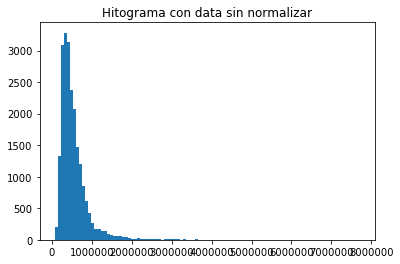

In [7]:
from matplotlib.pylab import hist, show

plt.title("Hitograma con data sin normalizar")
plt.hist(df['price'],bins=100)
plt.show()

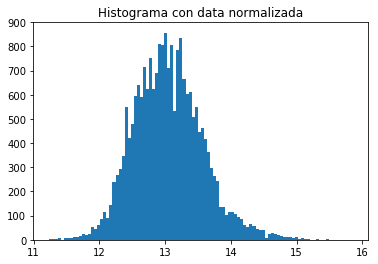

In [8]:
plt.title("Histograma con data normalizada")
plt.hist(y, bins=100)
plt.show()

In [146]:
df_scaled_train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,intercept
count,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,1.512900e+04,15129.0
mean,1.849785e-16,-3.789538e-17,4.719310e-17,3.861270e-17,-2.707568e-16,-7.205681e-16,4.689957e-16,3.856464e-16,1.383636e-15,-2.399649e-17,-1.015044e-16,5.131727e-16,-6.317132e-16,-1.266723e-14,2.541438e-14,-1.561753e-16,4.018495e-17,1.0
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,0.0
min,-3.695522e+00,-2.714893e+00,-1.844550e+00,-3.578749e-01,-8.478007e-01,-8.674852e-02,-3.101098e-01,-3.675091e+00,-3.940270e+00,-1.695150e+00,-6.746338e-01,-2.400159e+00,-2.174314e-01,-2.890957e+00,-2.184469e+00,-2.338019e+00,-4.573661e-01,1.0
25%,-3.963096e-01,-7.372207e-01,-7.074380e-01,-2.446882e-01,-8.478007e-01,-8.674852e-02,-3.101098e-01,-6.733930e-01,-5.071207e-01,-7.031746e-01,-6.746338e-01,-6.147711e-01,-2.174314e-01,-6.799023e-01,-8.048581e-01,-7.175202e-01,-2.870689e-01,1.0
50%,-3.963096e-01,-7.799663e-02,-1.775219e-01,-1.868669e-01,-8.478007e-01,-8.674852e-02,-3.101098e-01,-6.733930e-01,-5.071207e-01,-2.691856e-01,-6.746338e-01,6.367636e-02,-2.174314e-01,9.432470e-02,-1.150526e-01,-2.125067e-01,-2.007706e-01,1.0
75%,7.034278e-01,5.812274e-01,4.959132e-01,-1.122745e-01,1.113119e+00,-8.674852e-02,-3.101098e-01,8.274559e-01,3.511665e-01,4.747956e-01,6.581544e-01,8.135394e-01,-2.174314e-01,8.506629e-01,6.322367e-01,5.301602e-01,-1.110232e-01,1.0
max,8.401590e+00,7.832692e+00,1.268398e+01,3.825488e+01,4.054499e+00,1.152757e+01,4.846968e+00,2.328305e+00,4.642603e+00,9.501768e+00,1.003210e+01,1.706233e+00,4.645406e+00,1.557628e+00,6.466842e+00,6.144722e+00,3.081912e+01,1.0


## d)

In [10]:
import sklearn.linear_model as lm
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(df_scaled_train, ytrain)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

## e) Pesos y Z-score

Tenemos que los pesos asignados a cada variable serán los coeficientes $\hat{\beta}$ estimados en los puntos anteriores mediante el metodo de minimos cuadrados. Por otro lado tenemos que los Z-Score se obtienen siguien $\displaystyle z_i = \frac{\hat{\beta_i}}{\sigma_i\sqrt{v_i}}$, donde $v_i$ es el elemento $i-esimo$ de la diagonal de la matriz $(X^tX)^{-1}$

In [12]:
#Se carga el dataframe de los datos de entrenamiento en una arreglo para poder trabajar con los datos
def zscore(M):
    #X = np.array(df_scaled_train)
    #X = df_scaled_train.as_matrix()
    X = M
    #Se guarda la traspuesta de la matriz 
    Xt = np.transpose(X)
    #se computa el producto matricial entre la Xt y X 
    XtX = np.dot(Xt,X)
    # Se calcula la matriz de varianza-covarianza
    V = np.linalg.inv(XtX)
    # Se guarda la varianza (diagonal de la matriz)
    Vdiag = np.diag(V)
    #Se obtienen los coeficientes
    betas = linreg.coef_
    #se obtiene la desviacion estandar para cada variable
    sigma = df_scaled_train.std()
    #Se calculan los z-score
    z_score = betas/(sigma*np.sqrt(Vdiag))
    return np.array(z_score)

In [13]:
z_score = zscore(df_scaled_train.as_matrix())
d = {'1. Nombre_regresor' : df_scaled_train.columns,'2. Coeficientes' : pd.Series(linreg.coef_),'3. z-score': pd.Series(z_score)}
print(pd.DataFrame(d))

   1. Nombre_regresor  2. Coeficientes    3. z-score
0            bedrooms    -1.006993e-02 -9.603692e-01
1           bathrooms     5.484495e-02  3.706860e+00
2         sqft_living     6.534159e+11  1.090396e+07
3            sqft_lot     2.334097e-02  1.970461e+00
4              floors     3.583280e-02  3.147196e+00
5          waterfront     3.324101e-02  3.743769e+00
6                view     4.257007e-02  4.417291e+00
7           condition     4.609012e-02  5.189140e+00
8               grade     1.853509e-01  1.226781e+01
9          sqft_above    -5.817614e+11 -1.090396e+07
10      sqft_basement    -3.247474e+11 -1.090396e+07
11           yr_built    -1.051025e-01 -8.616066e+00
12       yr_renovated     1.535034e-02  1.760737e+00
13                lat     1.880493e-01  2.182469e+01
14               long    -4.280090e-03 -4.290158e-01
15      sqft_living15     8.435059e-02  5.985638e+00
16         sqft_lot15    -7.186890e-03 -5.996161e-01
17          intercept     1.303343e+01        

## f) K-fold cross-Validation

El sobreajuste es una complicacion que poseen la mayoria de algoritmos de machine learning, la cual conciste en ajustarse a caracteristicas muy especificas de los datos de entrenamiento provocando que el modelo pierda la capacidad de generalización. Una forma de lidiar con este problema es realizar una validacion cruzadada de los datos.

Para este item se usara el metodo de K-fold cross-validation con $k=5$ y $k=10$ respectivamente.


In [14]:
#Se normaliza la data de test
x_test = pd.DataFrame(scaler.transform(Xtest),columns=Xtest.columns)
#Se agrega la columna "intercept"
x_test.insert(x_test.shape[1], 'intercept', np.ones(x_test.shape[0]))
yhat_test = linreg.predict(x_test)
#Error estandar promedio cuadrado
mse_test = np.mean(np.power(yhat_test - ytest, 2))
print("Error estandar promedio", mse_test)
from sklearn.model_selection import KFold
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()

Error estandar promedio 0.06533782527951551


In [15]:
kf = KFold(n_splits=10)
mse_cv = 0
for train, val in kf.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler = StandardScaler().fit(Xm[train])
    df_cross_train = pd.DataFrame(cross_scaler.transform(Xm[train]),columns=Xtrain.columns)
    df_cross_train.insert(df_cross_train.shape[1], 'intercept',np.ones(df_cross_train.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train, ym[train])
    #Se normalizan los datos de test
    df_cross_test = pd.DataFrame(cross_scaler.transform(Xm[val]),columns=Xtrain.columns)
    df_cross_test.insert(df_cross_test.shape[1], 'intercept', np.ones(df_cross_test.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val = linreg.predict(df_cross_test)
    mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
    #print("Error del fold", mse_fold)
    mse_cv += mse_fold
mse_cv = mse_cv/10
print("Error promedio para k=10 ", mse_cv)

Error promedio para k=10  0.0646699469712


In [16]:
kf5 = KFold(n_splits=5)
mse_cv_k5 = 0
for train_k5, val_k5 in kf5.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler_k5 = StandardScaler().fit(Xm[train_k5])
    df_cross_train_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[train_k5]),columns=Xtrain.columns)
    df_cross_train_k5.insert(df_cross_train_k5.shape[1], 'intercept',np.ones(df_cross_train_k5.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train_k5, ym[train_k5])
    #Se normalizan los datos de test
    df_cross_test_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[val_k5]),columns=Xtrain.columns)
    df_cross_test_k5.insert(df_cross_test_k5.shape[1], 'intercept', np.ones(df_cross_test_k5.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val_k5 = linreg.predict(df_cross_test_k5)
    mse_fold_k5 = np.mean(np.power(yhat_val_k5 - ym[val_k5], 2))
    #print("Error del fold", mse_fold_k5)
    mse_cv_k5 += mse_fold_k5
mse_cv_k5 = mse_cv/10
print("Error promedio para k=5 ", mse_cv_k5)

Error promedio para k=5  0.00646699469712


Como podemos apreciar el error para este modelo es bastante bajo entre el target obtenido usando la data de test y el real, por lo que podemos concluir que el modelo no posee sobreajuste.

## 1-g) QQplot

****Los gráficos Q-Q son similares a los gráficos de probabilidad (que para una distribución normal se llaman gráficos de probabilidad normal o gráficos rankit). La diferencia es que en un gráfico de probabilidad, en lugar de usar el cuantil de la distribución como eje X, se usa la esperanza matemática del estadístico de k-ésimo orden de la distribución. Sólo cuando n es pequeño hay una diferencia sustancial entre un gráfico Q-Q y un gráfico de probabilidad.****

In [128]:
import scipy.stats as stats
from scipy.stats import norm

In [142]:
# se calcula la prediccion hecha por el modelo del target usando los datos de entrenamiento.
Xtrain = np.array(df_scaled_train)
yhat_train = linreg.predict(Xtrain)
#Se calcula el error o residuo usando los valores reales y los obteidos por la prediccion del modelo
e = np.array(ytrain) - yhat_train

print(np.max(yhat_train))
print(np.max(train))
print("----------")
print(np.min(yhat_train))
print(np.min(ytrain))

5118961890.57
13616
----------
-3642523450.7
11.2252433925


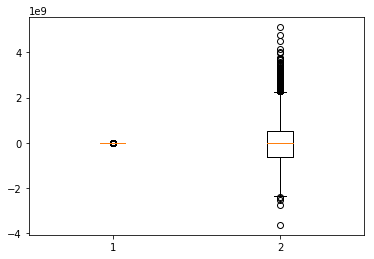

In [145]:
data = [ytrain, yhat_train]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

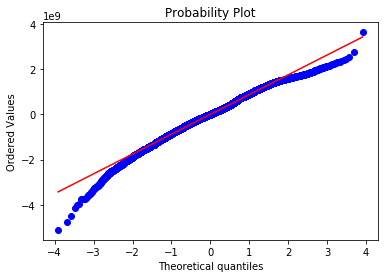

In [143]:
#Se realiza un grafico de probabilidado el cual nos entregara el mismo resultado que un QQplot ya que n es grande.
stats.probplot(e, dist="norm", plot=plt)
plt.show()

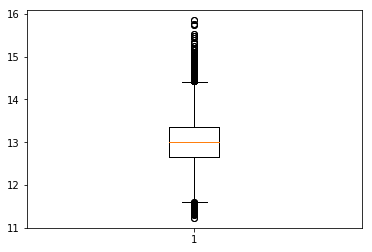

In [140]:
plt.boxplot(ytrain)
plt.show()

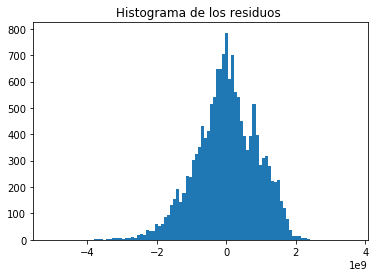

In [131]:
plt.title("Histograma de los residuos ")
plt.hist(e,bins=100)
plt.show()

## 1-h)

In [18]:
df_A = df.sample(3000)
frames = []
valor = np.log(df.price)
for z in np.arange(int(np.min(valor)),int(np.max(valor))+1,0.5):
    frames.append(df[(np.log(df.price) >= z) & (np.log(df.price) < z+0.5)].head(500))
df_B = pd.concat(frames).sample(3000)
X_A = df_A.iloc[:,1:].values
y_A = df_A.price
X_B = df_B.iloc[:,1:].values
y_B = df_B.price
from sklearn.model_selection import train_test_split
Xtrain_A, Xval_A, ytrain_A, yval_A = train_test_split(X_A, y_A, test_size=0.3, random_state=42)
Xtrain_B, Xval_B, ytrain_B, yval_B = train_test_split(X_B, y_B, test_size=0.3, random_state=42)